In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Defining the input valus for the BV equation

In [3]:
i0 = 2.55#...
alpha = 2#...
F = 96485#...
R = 8.314#...
T = 298#K
CO20 = 0.26 #mol/m3
COH0 = (10**-4)#mol/m3
#Eeq = 0.203 #
#Ect = -1.1#
OV = -0.075#
step = 10 #which means every 6 minutes
time_step = np.arange(0,60.001*60,step)# time duration of the experiment is 1 hour
concO2 = np.array([0.26])
concOH = np.array([10**-4])
current = np.array([0])
O2_limit = 10**-20

# Calculating the current and concentrations of O2 and OH

In [3]:
for i,t in enumerate(time_step):
    if i == len(time_step) - 1: 
        break
    
    iloc = i0*((concOH[i]*np.exp((alpha*F*OV)/(R*T))) - (concO2[i]*np.exp((-(alpha)*F*OV)/(R*T))))#BV equation
    RO2 = -1*abs(iloc)/(F*4) #Rate of O2 consumption
    ROH = 4*abs(iloc)/(F*4) #Rate of OH production
    newCurrent = iloc*0.0104
    current = np.append(current, newCurrent)
    #Concentration of oxygen
    new_concO2 = (RO2*step) + concO2[i] #Nerst equation to calculate new concentration
    if new_concO2 <= O2_limit:#for avoiding a negative value for O2
        concO2 = np.append(concO2, min(concO2))
        
        #Calculate the New conc of OH based on O2_limit
        concOH = np.append(concOH, max(concOH))
    else:
        concO2 = np.append(concO2, new_concO2)
        #Concentration of hydroxide
        new_concOH = (ROH*step) + concOH[i]
        concOH = np.append(concOH, new_concOH)
    

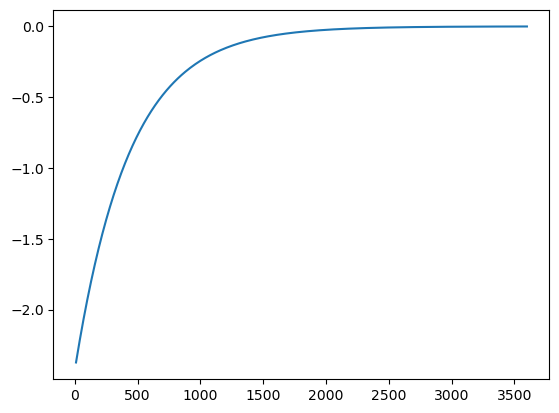

In [4]:
plt.plot(time_step[1:],current[1:])

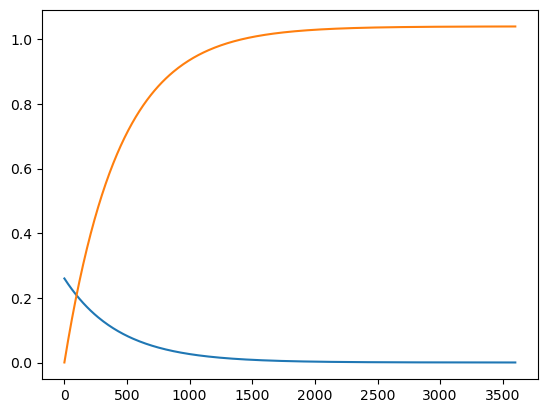

In [5]:
plt.plot(time_step,concO2,time_step,concOH)

# Now let's have a look into the diffusion

First, diffusion through the double layer (DL) without considering the rate of the BV reaction

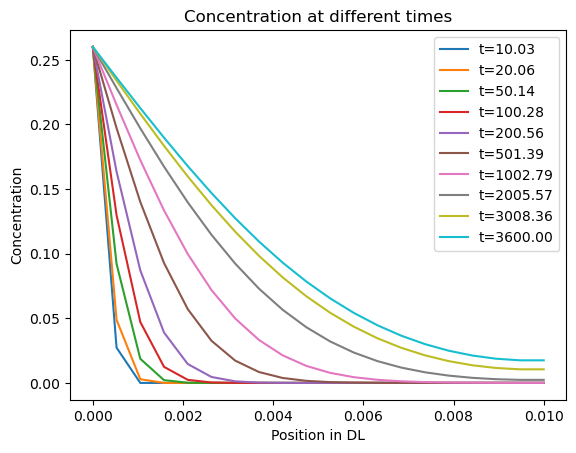

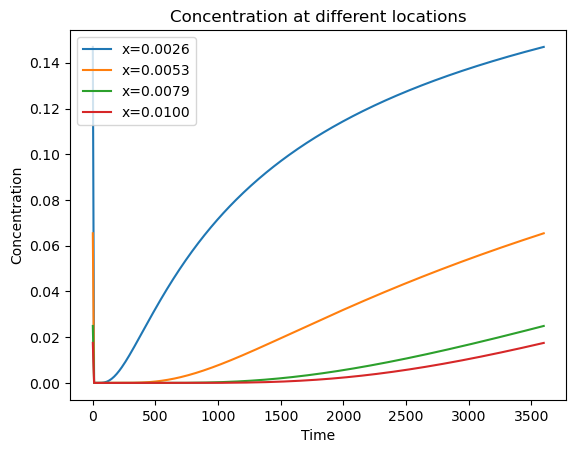

In [6]:
N = 20  # number of points to discretize
L = 0.01 # Considered length of DL, unit? 
X = np.linspace(0, L, N)  # position along the DL
h = L / (N - 1)  # discretization spacing

D = 2.9*10**-9  # Diffusivity, unit?

tfinal = 3600
Ntsteps = 360
dt = tfinal / (Ntsteps-1)
t = np.linspace(0, tfinal, Ntsteps)

alpha = D * dt / h**2


C_xt = []  # container for all the time steps

# initial condition (at t = 0)
C = np.zeros(X.shape)
C0t = 0.26  # concentration at x = 0, or bulk
C[0] = C0t

C_xt += [C]

for j in range(1, Ntsteps):
    N = np.zeros(C.shape)
    N[0] = C0t #BC1
    N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2] 
    N[-1] = N[-2]  # derivative boundary condition flux = 0,BC2 
    C[:] = N
    C_xt += [N]

    if j in [1, 2, 5, 10, 20, 50, 100, 200, 300, 359]:
        plt.plot(X, N, label="t={0:1.2f}".format(t[j]))

plt.xlabel("Position in DL")
plt.ylabel("Concentration")
plt.title("Concentration at different times")
plt.legend(loc="best")
plt.show()


C_xt = np.array(C_xt)
plt.figure()
# sns.set_palette(sns.color_palette("coolwarm",4))
plt.plot(t, C_xt[:, 5], label="x={0:1.4f}".format(X[5]))
plt.plot(t, C_xt[:, 10], label="x={0:1.4f}".format(X[10]))
plt.plot(t, C_xt[:, 15], label="x={0:1.4f}".format(X[15]))
plt.plot(t, C_xt[:, 19], label="x={0:1.4f}".format(X[19]))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration at different locations")
plt.show()


# It's time for combining the diffusion and BV!

Our first attempt,...

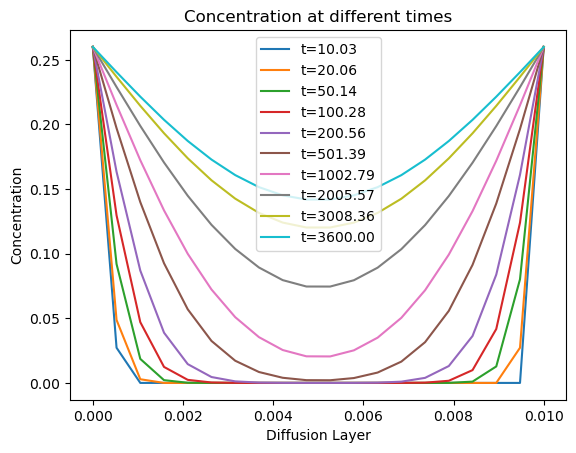

In [7]:
time_step = np.linspace(0, 60*60, 2)
for i,t in enumerate(time_step):
    if i == len(time_step) - 1:
        break
    
    
    iloc = i0*((concOH[i]*np.exp((alpha*F*OV)/(R*T))) - (concO2[i]*np.exp((-(alpha)*F*OV)/(R*T))))
    RO2 = -1*abs(iloc)/(F*4) #Rate of O2 consumption or flux at the surface 

    ROH = 4*abs(iloc)/(F*4) #Rate of OH production
    newCurrent = iloc*0.0104
    current = np.append(current, newCurrent)
    
    #Concentration of oxygen
    new_concO2 = (RO2*step) + concO2[i] #Nerst equation to calculate new concentration 
    BC2 = new_concO2 #Boundary condition 2, at the surface
    BC1 = 0.26 #Boundary condition 1, in the bulk
#   Diffusion
    N = 20  # number of points to discretize
    L = 0.01
    X = np.linspace(0, L, N)  # position along the rod
    h = L / (N - 1)  # discretization spacing

    #C0t = 0.26  # concentration at x = 0
    D = 2.9*10**-9  # Diffusivity

    tfinal = 3600
    Ntsteps = 360
    dt = tfinal / (Ntsteps)
    dt = 10
    t = np.linspace(0, tfinal, Ntsteps)
    alpha = D * dt / h**2
    C_xt = []  # container for all the time steps
    # initial condition at t = 0
    C = np.zeros(X.shape)
    C[0] = BC1

    C_xt += [C]

    for j in range(1, 360):
        N = np.zeros(C.shape)
        N[0] = BC1
        N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2] #+ (R*Ntsteps)
        N[-1] = BC2  # derivative boundary condition flux = 0
        C[:] = N
        C_xt += [N]

        # plot selective solutions
        # sns.set_palette(sns.color_palette("coolwarm",10))
        if j in [1, 2, 5, 10, 20, 50, 100, 200, 300, 359]:
            plt.plot(X, N, label="t={0:1.2f}".format(t[j]))
    # print(N)
    plt.xlabel("Diffusion Layer")
    plt.ylabel("Concentration")
    plt.title("Concentration at different times")
    plt.legend(loc="best")
    plt.show()
    
    if new_concO2 <= O2_limit:
        concO2 = np.append(concO2, min(concO2))
        
        #Calculate the New conc of OH based on O2_limit
        concOH = np.append(concOH, max(concOH))
    else:
        concO2 = np.append(concO2, new_concO2)
        #Concentration of hydroxide
        new_concOH = (ROH*step) + concOH[i]
        concOH = np.append(concOH, new_concOH)


It did not go well:( 

First of all, if we don't have the first line in the previous cell, an infinite loop will be made.

Second of all, cleary we cannot have two peaks at the two ends.

# So, we tried to base the BV on the amount that has been diffused at each moment,

This resulted in considering the second boundry condition a flux that is equal to RO2.

But to start simple, first a constant value for RO2 was taken into account:

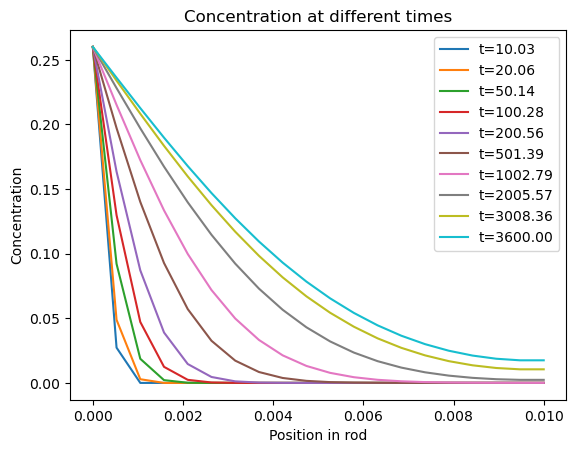

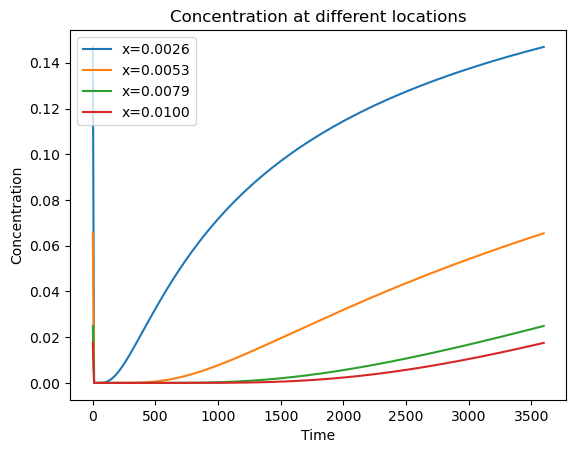

In [8]:
N = 20  # number of points to discretize
L = 0.01
X = np.linspace(0, L, N)  # position along the rod
h = L / (N - 1)  # discretization spacing

C0t = 0.26  # concentration at x = 0, BC1
D = 2.9*10**-9  # Diffusivity.  (Try increasing this to 0.028 or higher....)

tfinal = 3600
Ntsteps = 360
dt = tfinal / (Ntsteps-1)
t = np.linspace(0, tfinal, Ntsteps)

alpha = D * dt / h**2


C_xt = []  # container for all the time steps

RO2=0.0005914625586516863 #constant value for RO2
# initial condition at t = 0, IC
C = np.zeros(X.shape)
C[0] = C0t

C_xt += [C]

for j in range(1, Ntsteps):
    N = np.zeros(C.shape)
    N[0] = C0t
    N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2] #+ (R*Ntsteps)
    N[-1] = N[-2]+ (RO2*h) # derivative boundary condition flux = RO2, BC2
    C[:] = N
    C_xt += [N]

   
    if j in [1, 2, 5, 10, 20, 50, 100, 200, 300, 359 ]:
        plt.plot(X, N, label="t={0:1.2f}".format(t[j]))
plt.xlabel("Position in rod")
plt.ylabel("Concentration")
plt.title("Concentration at different times")
plt.legend(loc="best")
plt.show()


C_xt = np.array(C_xt)
plt.figure()
plt.plot(t, C_xt[:, 5], label="x={0:1.4f}".format(X[5]))
plt.plot(t, C_xt[:, 10], label="x={0:1.4f}".format(X[10]))
plt.plot(t, C_xt[:, 15], label="x={0:1.4f}".format(X[15]))
plt.plot(t, C_xt[:, 19], label="x={0:1.4f}".format(X[19]))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration at different locations")
plt.show()

The RO2 is so small that it did not change the concentration profile much in comparison to when we only had diffusion.

# Now, let's include the different RO2s in the code

Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Sa

Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated
Not Saturated


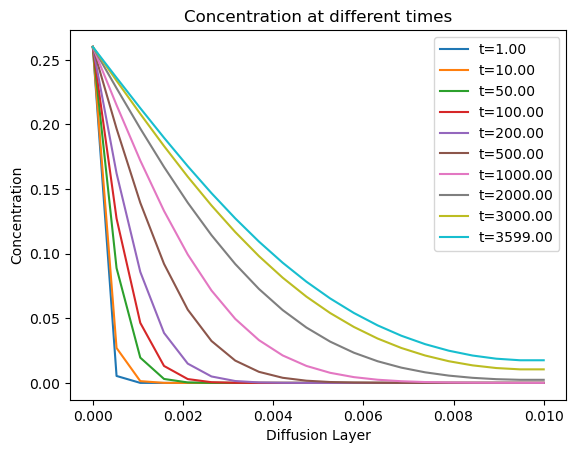

In [12]:
BC1 = CO20 #Boundary condition 1, in the bulk


#   Diffusion
N = 20  # number of points to discretize
L = 0.01
X = np.linspace(0, L, N)  # position along the rod
h = L / (N - 1)  # discretization spacing

#C0t = 0.26  # concentration at x = 0
D = 2.9*10**-9  # Diffusivity

tfinal = 3600 # 1 hour
Ntsteps = 3601
dt = tfinal / (Ntsteps-1)
t = np.linspace(0, tfinal, Ntsteps)

alpha = D * dt / h**2


C_xt = []  # container for all the time steps

# initial condition at t = 0
C = np.zeros(X.shape)
C[0] = BC1

C_xt += [C]

current = np.array([])

for j in range(tfinal):
    N = np.zeros(C.shape)
    N[0] = BC1
    N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
    if N[-2] < 0.25: #to give it some time until the solution gets saturated
        print('Not Saturated')
        N[-1] = N[-2]  # derivative boundary condition flux = 0
        current = np.append(current, 0)
        concOH = np.append(concOH, concOH[0])
        
    else: #after the solution is saturated with O2
        print('Saturated')
        
        iloc = i0*((concOH[j]*np.exp((alpha*F*OV)/(R*T))) - (N[-2]*np.exp((-(alpha)*F*OV)/(R*T)))) #Current density
        
        RO2 = -1*abs(iloc)/(F*4) #Rate of O2 consumption or flux at the surface 
        
        N[-1] = (RO2*h) + N[-2]  # derivative boundary condition flux = RO2, BC2
        
        ROH = 4*abs(iloc)/(F*4) #Rate of OH production
        
        new_concOH = (ROH*h) + concOH[j]
        
        concOH = np.append(concOH, new_concOH)
        
        newCurrent = iloc*0.0104
        
        current = np.append(current, newCurrent)
        
    C[:] = N #Crucial for the loop

    if j in [1, 10, 50, 100, 200, 500, 1000, 2000, 3000, 3599]:
        C_xt += [N]
        plt.plot(X, N, label="t={0:1.2f}".format(t [j]))
        
plt.xlabel("Diffusion Layer")
plt.ylabel("Concentration")
# plt.ylim(0,0.05)
plt.title("Concentration at different times")
plt.legend(loc="best")
plt.show()

It shows it is not any close to saturation yet, so let's give it more time:

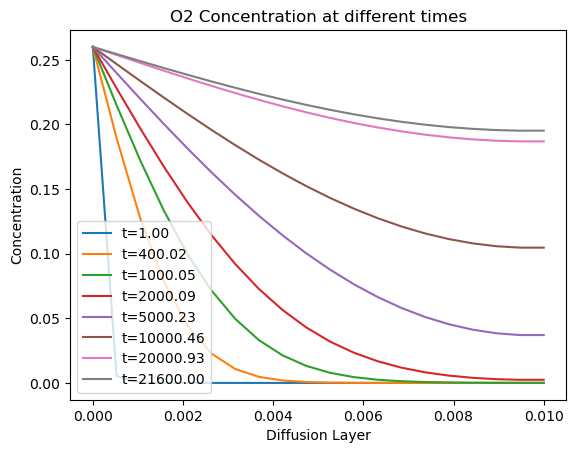

In [12]:
BC1 = CO20 #Boundary condition 1, in the bulk

#   Diffusion
N = 20  # number of points to discretize
L = 0.01
X = np.linspace(0, L, N)  # position along the rod
h = L / (N - 1)  # discretization spacing


D = 2.9*10**-9  # Diffusivity

tfinal = 21600 #6 hours
Ntsteps = 21600
dt = tfinal / (Ntsteps-1)
t = np.linspace(0, tfinal, Ntsteps)
alpha = D * dt / h**2


C_xt = []  # container for all the time steps

# initial condition at t = 0
C = np.zeros(X.shape)
C[0] = BC1

C_xt += [C]

current = np.array([])

for j in range(tfinal):
    N = np.zeros(C.shape)
    N[0] = BC1
    N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
    if N[-2] < 0.15: #to give it some time until the solution gets to a degree of saturation
        #print('Not Saturated')
        N[-1] = N[-2]  # derivative boundary condition flux = 0
        current = np.append(current, 0)
        concOH = np.append(concOH, concOH[0])
        concO2 = np.append(concO2, N[-1])
        
    else: #after the solution is saturated with O2
        #print('Saturated')
        iloc = i0*((concOH[j]*np.exp((alpha*F*OV)/(R*T))) - (N[-2]*np.exp((-(alpha)*F*OV)/(R*T)))) #Current density

        RO2 = -1*abs(iloc)/(F*4) #Rate of O2 consumption or flux at the surface 
        
        N[-1] = (RO2*h) + N[-2]  # derivative boundary condition flux = RO2, BC2
        new_concO2 = N[-1]
        concO2 = np.append(concO2, new_concO2)

        ROH = 4*abs(iloc)/(F*4) #Rate of OH production

        new_concOH = (ROH*h) + concOH[j]
        
        concOH = np.append(concOH, new_concOH)

        newCurrent = iloc*0.0104

        current = np.append(current, newCurrent)

    C[:] = N #Crucial for the loop
#         C_xt += [N]
    if j in [1, 400, 1000, 2000, 5000, 10000, 20000,21599]:
        #C_xt += [N]
        plt.plot(X, N, label="t={0:1.2f}".format(t[j]))
        
plt.xlabel("Diffusion Layer")
plt.ylabel("Concentration")
# plt.ylim(0,0.05)
plt.title("O2 Concentration at different times")
plt.legend(loc="best")
plt.show()



Now this looks much better. 

Let's se the current, O2, OH, and pH change behavior:

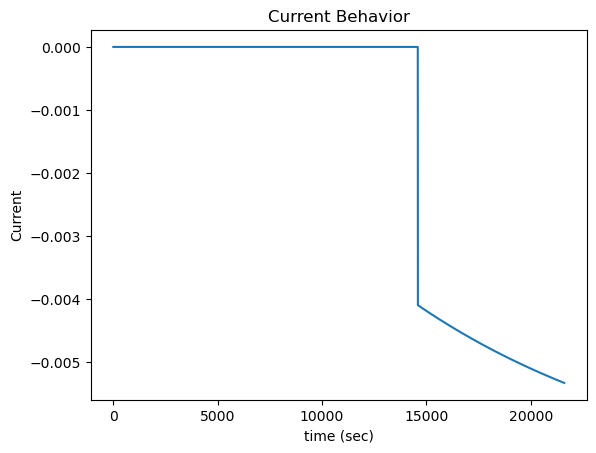

In [15]:
plt.plot(t[0:21599], current[0:21599])
plt.xlabel("time (sec)")
plt.ylabel("Current")

plt.title("Current Behavior")

plt.show()

The current keeps increasing with supplying more O2, but after some point this increase slows down.

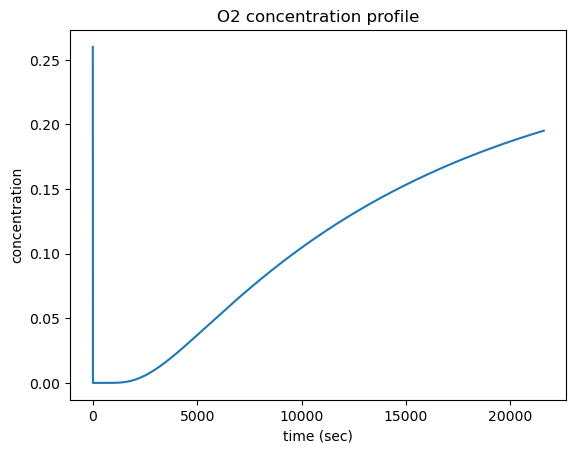

In [16]:
plt.plot(t[0:21599], concO2[0:21599])
plt.xlabel("time (sec)")
plt.ylabel("concentration")

plt.title("O2 concentration profile")

plt.show()

O2 keeps increasing cause a continuous supply of O2 sparging is assumed.

But, it reaches to a plateau when saturated.

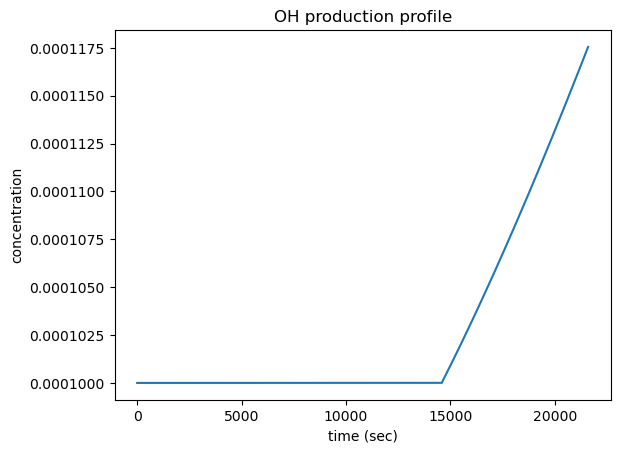

In [17]:
plt.plot(t[0:21599], concOH[0:21599])
plt.xlabel("time (sec)")
plt.ylabel("concentration")

plt.title("OH production profile")

plt.show()

OH production is assumed to satart after a certain amount of saturation is acheived.

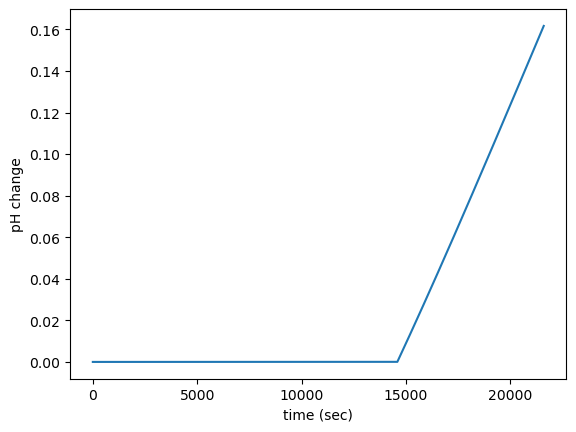

In [22]:
pH = 14 + np.log(concOH[0:21599])
pHChange= pH-pH[0]
plt.plot(t[0:21599], pHChange)
plt.xlabel("time (sec)")
plt.ylabel("pH change")



plt.show()

This chart shows the change in the pH due to the electrochemical reduction of O2. 